# Single neuron tutorial

This exercice aims at understanding the capacities of a single artificial neuron.

<img src="graphics/neuron2.png">



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Magic used by the notebook to show figures inline
%matplotlib inline
# matplotlib default values
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading packages
%load_ext autoreload
%autoreload 2

random_seed = 4

## Data for classification problems

The data below correspond to classification problems. Each input dataset $X$ contains points of $\mathbb{R}^2$. The output datasets $y$ give one of two classes, coded as $0$ or $1$, to each point.


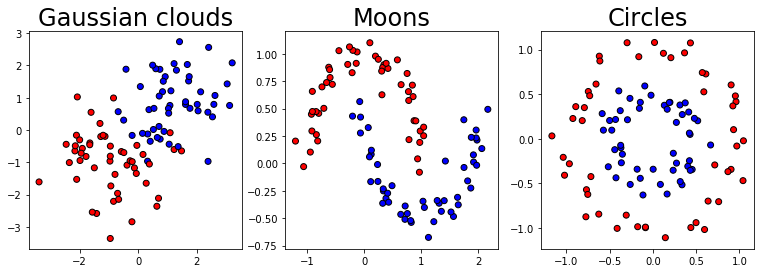

In [5]:
# Load and display data
from sklearn.datasets import make_moons, make_circles, make_blobs

figure = plt.figure(figsize=(13, 4))
cm = plt.cm.RdBu
cm_red_blue = ListedColormap(['#FF0000', '#0000FF'])

# Linearly separable
X_lin, y_lin = make_blobs(n_features=2, random_state=random_seed, centers=[[-1, -1], [1, 1]])
ax = plt.subplot(1, 3, 1)
ax.set_title("Gaussian clouds", fontsize=24)
ax.scatter(X_lin[:, 0], X_lin[:, 1], c=y_lin, cmap=cm_red_blue,
               edgecolors='k')

# Moons
X_moons, y_moons = make_moons(noise=0.1, random_state=random_seed)
ax = plt.subplot(1, 3, 2)
ax.set_title("Moons", fontsize=24)
ax.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=cm_red_blue,
               edgecolors='k')

# Circles (factor: ratio between inner and outer circles radius)
X_circ, y_circ = make_circles(noise=0.1, factor=0.5, random_state=random_seed)
ax = plt.subplot(1, 3, 3)
ax.set_title("Circles", fontsize=24)
ax.scatter(X_circ[:, 0], X_circ[:, 1], c=y_circ, cmap=cm_red_blue,
               edgecolors='k')

datasets = {"lin": [X_lin, y_lin], "circ": [X_circ, y_circ], "moons": [X_moons, y_moons]}

plt.show()
   

In [3]:
# Chosing the data set that will be used in the following
my_set = "circ"  # can be any of "lin", "circ" or "moons"
X_sel = datasets[my_set][0]
y_sel = datasets[my_set][1]


## Artificial neuron

This neuron model takes two inputs $\textbf{x} = (x_0, x_1)$ , applies to them an affine transformation with weights $\textbf{w} = (w_0, w_1)$ and bias $b$ and then sends the output through and activation function $g$:

$$(x_1, x_2) \mapsto g(b + w_0 x_0 + w_1 x_1)$$

The loss function here is the squared error.

In [ ]:

class ArtificialNeuron2d(object):
    """Artificial neuron with two inputs.
    
    Activation: to be chosen at instantiation time.
    Loss: squared error.
    Optimization method: backpropagation.
    """
    def __init__(self, act, random_state=None, sigma=0.01):
        """Initialization
        
        Parameters:
        act: an activation class from activations.py.
        random_state: None means that no random seed is given.
        sigma: standard deviation of the normal random variable used for initializing the weights.
        """
        self.activation = act() # act is a class; has to be instantiated
        np.random.seed(random_state)
        self.sigma = sigma
        self.w, self.b = self.init_weights()
        self.dL_dw = None
        self.dL_db = None
        self.dL_dt = None
        self.dL_dy = None
    
    def init_weights(self):
        return np.random.randn(2) * self.sigma, np.random.randn(1) * self.sigma
    
    def predict(self, x):
        """Compute neuron prediction.
        
        x: numpy array containing 2 elements.
        """
        return self.activation(self.b + np.dot(self.w, x))
    
    def print_gradients(self):
        print("dL/dy = ", self.dL_dy)
        print("dL/dt = ", self.dL_dt)
        print("dL/db = ", self.dL_db)
        print("dL/dw = ", self.dL_dw)
    
    def forward_back_propagation(self, x, y_gt, learning_rate, verbose=False):
        """Forward pass, backward pass with parameters update, on a single sample.
        
        x: numpy array containing a single training sample (two coordinates).
        y_gt: expected output (ground-truth).
        learning_rate: positive real value, typically smaller than 1.
        verbose: toggles verbose mode
        
        Returns:
        l: loss value for the given input (before back propagation)
        """
        # Compute forward pass and local gradients
        t = self.b + np.dot(self.w, x)
        dt_dw = x
        dt_db = 1
        
        y = self.activation(t)
        dy_dt = self.activation.grad(t)
        
        L = np.square(y - y_gt).sum() # Note: this value is not used in the optimization. It is only returned by the function.
        if verbose is True: print("Predicted output (y): ", y)
        
        # Back propagate gradient
        self.dL_dy = 2 * (y - y_gt)
        self.dL_dt = self.dL_dy * dy_dt
        self.dL_db = self.dL_dt * dt_db
        self.dL_dw = self.dL_dt * dt_dw
        
        # Update parameters
        self.b = self.b - learning_rate * self.dL_db
        self.w = self.w - learning_rate * self.dL_dw

        return L
        

    def batch_forward_back_propagation(self, x, y_gt, learning_rate, verbose=False):
        """Forward pass, backward pass with parameters update, on mini-batch.
        
        x: numpy array containing n training samples.
        y_gt: expected output (ground-truth).
        learning_rate: positive real value, typically smaller than 1.
        verbose: toggles verbose mode
        
        Returns:
        l: loss value for the given batch (before back propagation)
        """
        n = x.shape[0]
        # Compute forward pass and local gradients
        t = np.matmul(x, self.w) + self.b
        dt_dw = np.mean(x, axis=0)
        dt_db = 1
        
        y = self.activation(t)
        dy_dt = np.mean(self.activation.grad(t))
        
        # Note: this value is not used in the optimization. It is only returned by the function.
        L = np.square((y - y_gt) ** 2).sum()  # scalar
        if verbose is True: print("Predicted output (y): ", y)
        
        # Back propagate gradient
        self.dL_dy = 2 * np.mean(y - y_gt)
        self.dL_dt = self.dL_dy * dy_dt
        self.dL_db = self.dL_dt * dt_db
        self.dL_dw = self.dL_dt * dt_dw
        
        # Update parameters
        self.b = self.b - learning_rate * self.dL_db
        self.w = self.w - learning_rate * self.dL_dw

        return L
        
        
    def fit(self, X, Y, epochs, learning_rate, batch=1, verbose=False):
        """Learn model using gradient descent.
        
        X: input examples
        Y: output examples
        learning_rate: learning rate
        batch: size of mini-batch
        verbose: toggle verbose mode
        """
        loss_hist = []
        for epoch in range(epochs):
            epoch_loss_list = []
            if batch == 1:
                for (x, y) in zip(X, Y):
                    epoch_loss_list += [self.forward_back_propagation(x, y, learning_rate)]
            if batch > 1:
                n = X.shape[0]  # number of samples
                for i in range(n // batch):
                    x = X[i * batch: (i+1) * batch]
                    y = Y[i * batch: (i+1) * batch]
                    epoch_loss_list += [self.batch_forward_back_propagation(x, y, learning_rate)]
            if verbose is True: print("Epoch ", epoch, " : loss = ", np.mean(epoch_loss_list))
            loss_hist += [np.mean(epoch_loss_list)]
                
        return loss_hist
        

## Activations

We are now going to choose the activation that will be used by the neuron. Some among the most popular ones are avaible in the activations.py file. You can choose between:

* ActivationSigmoid
* ActivationTanh
* ActivationRelu
* ActivationIdentity

__Question__: given the classification problem presented above, what activation would be the most appropriate?

In [ ]:
from dlia_tools import activations

act = activations.ActivationSigmoid

## Creating the artificial neuron

We will now "instantiate" the neuron and see what the initial predictions are, without any adaptation to the dataset.

In [ ]:
# Instantiate artificial neuron and begin playing with it
an = ArtificialNeuron2d(act, random_state=random_seed)
print("Model params:", an.w, an.b)

# Create grid for visualization
h = 0.1
x0_min = X_sel[:, 0].min() - h
x0_max = X_sel[:, 0].max() + h
x1_min = X_sel[:, 1].min() - h
x1_max = X_sel[:, 1].max() + h
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h), np.arange(x1_min, x1_max, h))
xx0_ravel = xx0.ravel()
xx1_ravel = xx1.ravel()



## Training a single epoch 

The objective of the training is that our simple model, made out of a single neuron, predicts for each point of $\cal{R}^2$ its "correct" class.

The model is trained using a gradient descent, point by point. The learning rate parameter plays an important role in the optimization procedure.

We will first train for a single epoch, an see how the prediction on the whole grid evolves. The result can be compared to the precedent one, obtained with random weights.

In [ ]:
# Train a single epoch - look at the evolution of the model
loss = []
learning_rate = 0.01
for (x, y) in zip(X_sel, y_sel):
    loss += [an.forward_back_propagation(x, y, learning_rate)]
# print("Model params:", an.w, an.b)
print("Mean loss: ", np.mean(loss))
# an.print_gradients()

# predict on all grid points
i = 0
y_pred_ravel = np.zeros(len(xx0_ravel))
for (x0, x1) in zip(xx0_ravel, xx1_ravel):
    y_pred_ravel[i] = an.predict(np.array([x0, x1]))
    i += 1
y_pred = y_pred_ravel.reshape(xx0.shape)

# Plot current model
figure = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
ax.set_title("Current prediction")
ax.contourf(xx0, xx1, y_pred, cmap=cm, alpha=.8)
ax.scatter(X_sel[:, 0], X_sel[:, 1], c=y_sel, cmap=cm_red_blue,
               edgecolors='k')
plt.show()

In [ ]:
# Take a new neuron
an = ArtificialNeuron2d(act, random_state=random_seed)

# Train N epochs
epochs = 200
learning_rate = 0.1
loss_hist = an.fit(X_sel, y_sel, epochs, learning_rate, batch=10 )
print("Final loss: ", loss_hist[-1])

# predict on all grid points
i = 0
for (x0, x1) in zip(xx0_ravel, xx1_ravel):
    y_pred_ravel[i] = an.predict(np.array([x0, x1]))
    i += 1
y_pred = y_pred_ravel.reshape(xx0.shape)

# Plot current model
figure = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
ax.set_title("Current prediction")
ax.contourf(xx0, xx1, y_pred, cmap=cm, alpha=.8)
ax.scatter(X_sel[:, 0], X_sel[:, 1], c=y_sel, cmap=cm_red_blue, edgecolors='k')
# ax.scatter(xx0, xx1, c=y_pred, cmap=cm_red_blue, edgecolors='k')
plt.show()

In [ ]:
print(len(loss_hist))
plt.plot(loss_hist)
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
print(y_pred_ravel[0:10])